In [1]:
# Import necessary modules
import glob
import json
import numpy as np
import math
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import subprocess
import sys

from datetime import datetime, timedelta
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle, Circle
from mpl_toolkits.mplot3d import Axes3D

## Helper functions

## Model Parameters

In [2]:
# Plant height constants
kh = 3.0     # m
h0 = kh/3000 # m/hr
ah = 0.01    # 1/hr

# Leaf area
kA = 0.65    # m2
A0 = kA/3000 # m2/hr
aA = 0.0105   # 1/hr

# Number of leaves
kN = 20      # number of leaves
N0 = kN/3000 # number/hr
aN = 0.011  # 1/hr

# Flower size
kc = 1000     # number of spikelets
c0 = kc/3000  # number/hr
ac = 0.01     # 1/hr

# Fruit biomass
kP = 0.25     # kg
P0 = kP/3000  # kg/hr
aP = 0.005   # 1/hr

# Simulation settings
dt = 0.1 # hours/step
simulation_hours = 2900 # hours
total_time_steps = int(simulation_hours/dt) # steps

# Note for later: Richard's growth as an alternative to logistic growth?

In [3]:
# Initialize storage for variables
h = h0 * np.ones(total_time_steps) # height
A = A0 * np.ones(total_time_steps) # leaf area
N = N0 * np.ones(total_time_steps) # number of leaves
c = c0 * np.ones(total_time_steps) # flower size
P = P0 * np.ones(total_time_steps) # fruit biomass

# Initialize storage for cumulative irrigation and fertilizer consumption
cumulative_water = np.zeros(total_time_steps)
cumulative_fertilizer = np.zeros(total_time_steps)

## Input Disturbances

In [4]:
# Hourly irrigation, fertilizer, and temperature
hourly_df = pd.read_csv('../io/inputs/hourly_prcp_rad_temp_iowa.csv', header=None, names=['Hourly Precipitation (mm)', 'Hourly Radiation (W)', 'Temperature (C)'])
hourly_precipitation = hourly_df['Hourly Precipitation (mm)'].to_numpy()
hourly_radiation = hourly_df['Hourly Radiation (W)'].to_numpy()
hourly_temperature = hourly_df['Temperature (C)'].to_numpy()

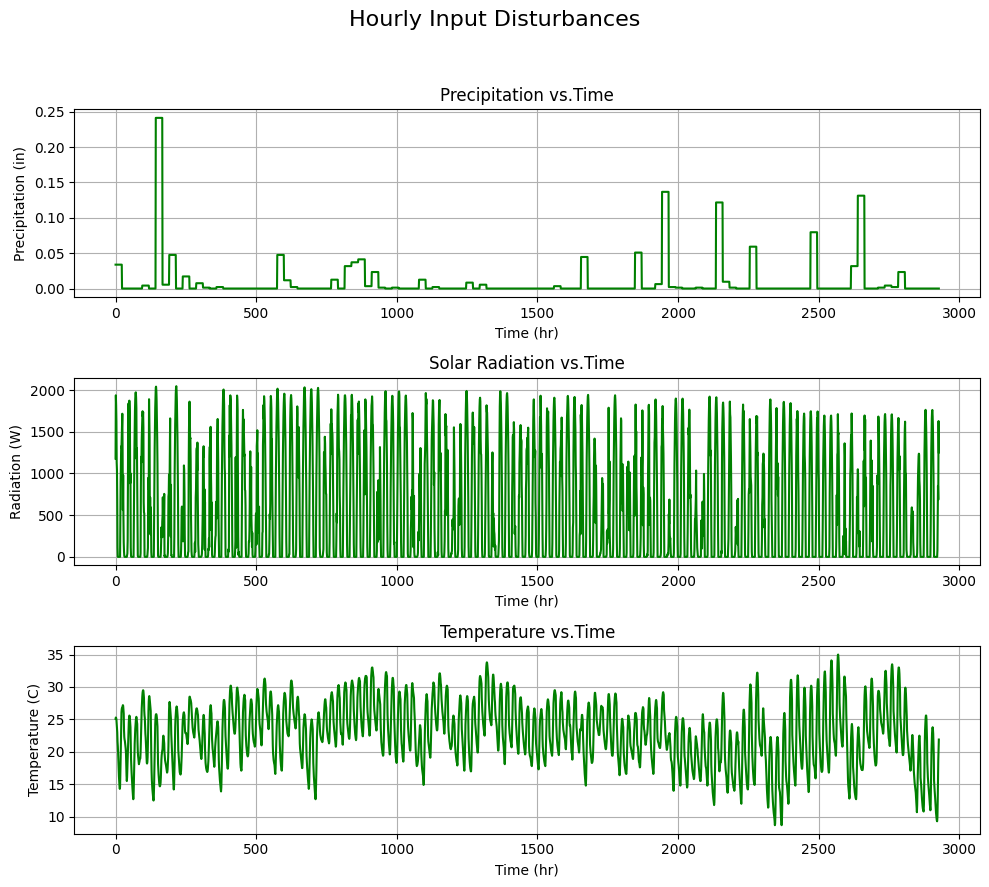

In [5]:
# Plot all of the input disturbances
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
time = np.arange(len(hourly_precipitation))

# Precipitation
axs[0].plot(time, hourly_precipitation, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Precipitation (in)')
axs[0].set_title(f'Precipitation vs.Time')
axs[0].grid(True)

# Solar Radiation
axs[1].plot(time, hourly_radiation, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Radiation (W)')
axs[1].set_title(f'Solar Radiation vs.Time')
axs[1].grid(True)

# Fruit Biomass
axs[2].plot(time, hourly_temperature, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Temperature (C)')
axs[2].set_title(f'Temperature vs.Time')
axs[2].grid(True)

fig.suptitle(f'Hourly Input Disturbances', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

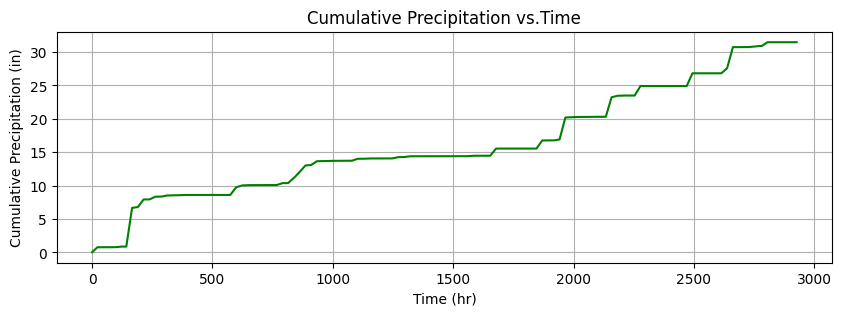

In [6]:
# Plot cumulative precipitation
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
time = np.arange(len(hourly_precipitation))

# Calculate cumulative precipitation
cumulative_precipitation = np.cumsum(hourly_precipitation)

# Precipitation
axs.plot(time, cumulative_precipitation, color='green')
axs.set_xlabel('Time (hr)')
axs.set_ylabel('Cumulative Precipitation (in)')
axs.set_title(f'Cumulative Precipitation vs.Time')
axs.grid(True)

## Control inputs

In [7]:
# Genetic algorithm style inputs
irrigation_frequency = 5*24    # once every X hours
irrigation_amount    = 1       # inches/acre per irrigation
fertilizer_frequency = 30 * 24 # once every X hours (~once a month)
fertilizer_amount    = 118     # pounds/acre per fertilization

In [8]:
# Apply irrigation and fertilizer based on the defined frequency and amount
hourly_irrigation = np.zeros(simulation_hours)
for t in range(0, simulation_hours, irrigation_frequency):
    hourly_irrigation[t] = irrigation_amount

hourly_fertilizer = np.zeros(simulation_hours)
for t in range(0, simulation_hours, fertilizer_frequency):
    hourly_fertilizer[t] = fertilizer_amount

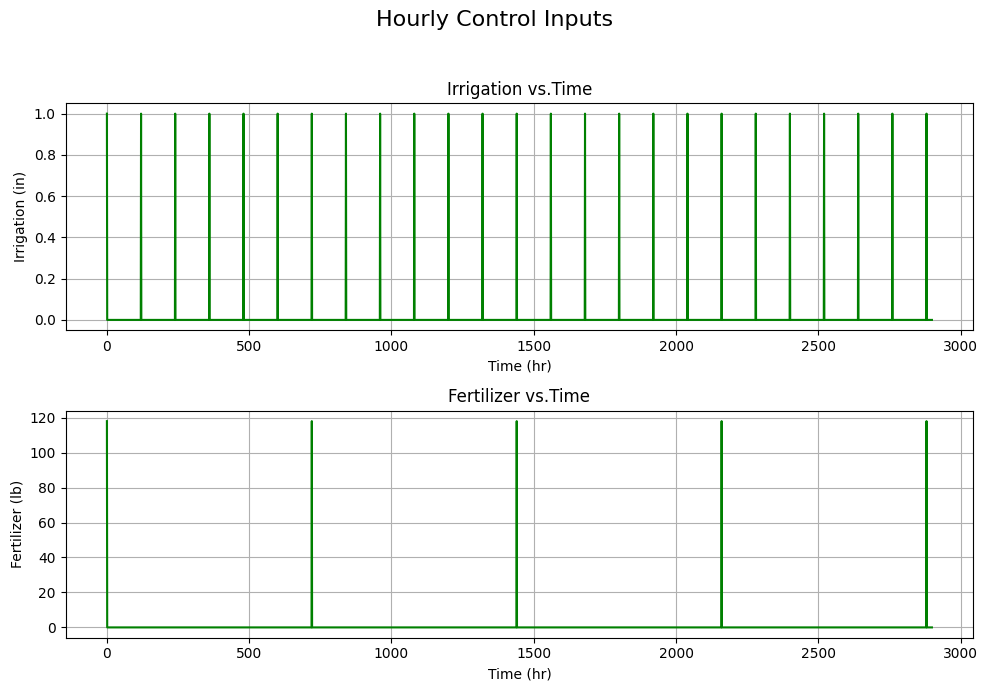

In [9]:
# Plot all of the control inputs
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
time = np.arange(simulation_hours)

# Irrigation
axs[0].plot(time, hourly_irrigation, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Irrigation (in)')
axs[0].set_title(f'Irrigation vs.Time')
axs[0].grid(True)

# Fertilizer
axs[1].plot(time, hourly_fertilizer, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Fertilizer (lb)')
axs[1].set_title(f'Fertilizer vs.Time')
axs[1].grid(True)

fig.suptitle(f'Hourly Control Inputs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Nutrient Factors

In [10]:
# To calculate the "nutrient factors", we need to know the following
FC_opt = 355 # lbs/acre per season, cumulative fertilizer consumption
WC_opt = 28  # inches/acre per season, cumulative water consumption

T_typ = np.mean(hourly_temperature) # typical temperature over the season
R_typ = np.mean(hourly_radiation)   # typical radiation over the season

In [11]:
# # Nutrient factors are based on a sigma=1 Gaussian distribution
'''
def get_nutrient_factor(x, mu, threshold):
    nu = np.exp( 1/2 * (x/mu - 1)**2 * np.log(threshold))
    return nu
'''

def get_nutrient_factor(x, mu):
    nu = 1/2 * (1 / (1 + np.exp(1/100*(x - mu))) + 1)
    return nu

## Convert hourly values to whatever the total number of time steps is

In [12]:
def get_sim_inputs_from_hourly(
        hourly_array,
        dt,
        simulation_hours,
        mode='copy' # 'copy' or 'split'
    ):

    # Initialize the output array
    total_time_steps = int(simulation_hours / dt)
    simulation_array = np.zeros(total_time_steps)

    # Truncate hourly_df to length simulation_hours
    hourly_array = hourly_array[:simulation_hours]

    # Time steps per hour
    time_steps_per_hour = int(1 / dt)

    # Loop over the hours and fill the simulation_df with the extra timesteps
    for i in range(simulation_hours):
        hourly_value = hourly_array[i]

        if mode == 'copy':
            simulation_array[i*time_steps_per_hour:(i+1)*time_steps_per_hour] = hourly_value
        elif mode == 'split':
            simulation_array[i*time_steps_per_hour:(i+1)*time_steps_per_hour] = hourly_value/time_steps_per_hour

    return simulation_array

In [13]:
precipitation = get_sim_inputs_from_hourly(hourly_array=hourly_precipitation, dt=dt, simulation_hours=simulation_hours, mode='split')
radiation = get_sim_inputs_from_hourly(hourly_array=hourly_radiation, dt=dt, simulation_hours=simulation_hours, mode='copy')
temperature = get_sim_inputs_from_hourly(hourly_array=hourly_temperature, dt=dt, simulation_hours=simulation_hours, mode='copy')
irrigation = get_sim_inputs_from_hourly(hourly_array=hourly_irrigation, dt=dt, simulation_hours=simulation_hours, mode='split')
fertilizer = get_sim_inputs_from_hourly(hourly_array=hourly_fertilizer, dt=dt, simulation_hours=simulation_hours, mode='split')

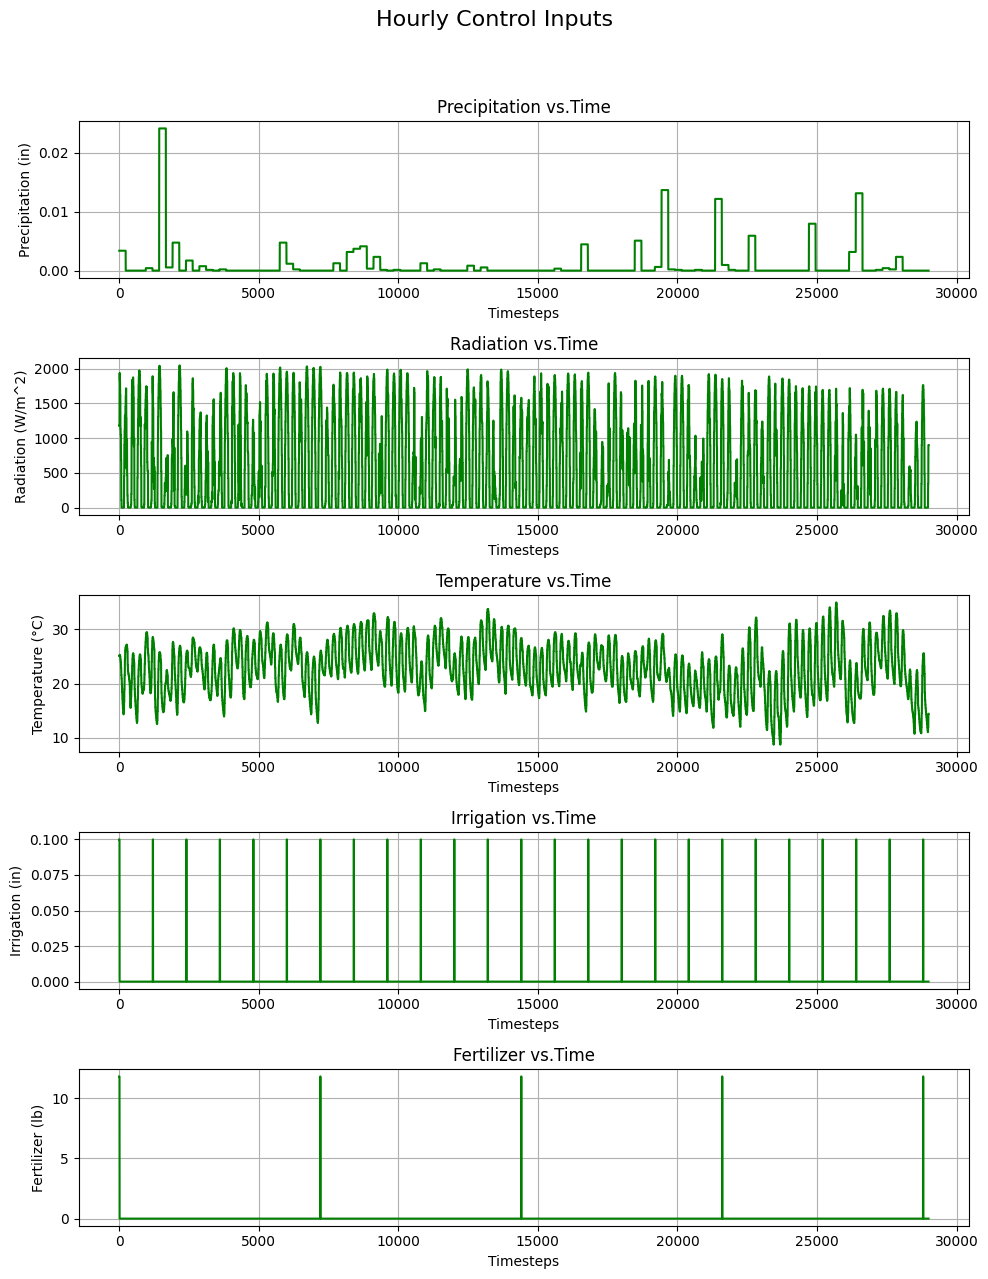

In [14]:
# Plot all of the control inputs
fig, axs = plt.subplots(5, 1, figsize=(10, 13))
total_time_steps = int(simulation_hours / dt)
time = np.arange(total_time_steps)

# Precipitation
axs[0].plot(time, precipitation, color='green')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Precipitation (in)')
axs[0].set_title(f'Precipitation vs.Time')
axs[0].grid(True)

# Radiation
axs[1].plot(time, radiation, color='green')
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('Radiation (W/m^2)')
axs[1].set_title(f'Radiation vs.Time')
axs[1].grid(True)

# Irrigation
axs[2].plot(time, temperature, color='green')
axs[2].set_xlabel('Timesteps')
axs[2].set_ylabel('Temperature (°C)')
axs[2].set_title(f'Temperature vs.Time')
axs[2].grid(True)

# Irrigation
axs[3].plot(time, irrigation, color='green')
axs[3].set_xlabel('Timesteps')
axs[3].set_ylabel('Irrigation (in)')
axs[3].set_title(f'Irrigation vs.Time')
axs[3].grid(True)

# Fertilizer
axs[4].plot(time, fertilizer, color='green')
axs[4].set_xlabel('Timesteps')
axs[4].set_ylabel('Fertilizer (lb)')
axs[4].set_title(f'Fertilizer vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Control Inputs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Run simulation

In [16]:
# Run Simulation
time_steps_per_hour = int(1 / dt)
time_steps_per_day = 24 * time_steps_per_hour

#for t in range((total_time_steps-1)):
for t in range(100):

   # Read-in input disturbances (temperature, radiation, but not precipitation)
   T = temperature[t]
   R = radiation[t]

   # Update cumulative values
   WC = cumulative_water[t] + irrigation[t] + precipitation[t]
   cumulative_water[t+1] = WC

   FC = cumulative_fertilizer[t] + fertilizer[t]
   cumulative_fertilizer[t+1] = FC

   # Calculate "nutrient factors" based on inputs
   nuW = get_nutrient_factor(x=WC, mu=WC_opt)  # Water nutrient factor
   nuF = get_nutrient_factor(x=FC, mu=FC_opt)  # Fertilizer nutrient factor
   nuT = get_nutrient_factor(x=T,  mu=T_typ)   # Temperature nutrient factor
   nuR = get_nutrient_factor(x=R,  mu=R_typ)   # Radiation nutrient factor

   # Calculate modified growth rates based on nutrient factors
   ah_hat = ah * ( nuF * nuT * nuR )**(1/3) # height growth rate
   aA_hat = aA * ( nuF * nuT * nuR )**(1/3) # leaf area growth rate
   aN_hat = aN                              # number of leaves growth rate
   ac_hat = ac * ( 1/nuT * 1/nuR )**(1/2)   # flower size growth rate
   aP_hat = aP * ( nuT * nuR )**(1/2)       # fruit biomass growth rate

   # Calculate modified carrying capacities based on nutrient factors
   kh_hat = kh * ( nuF * nuT * nuR )**(1/3)                  # height carrying capacity
   kA_hat = kA * ( nuW * nuF * nuT * nuR * kh_hat/kh)**(1/5) # leaf area carrying capacity
   kN_hat = kN * ( nuT * nuR )**(1/2)                        # number of leaves carrying capacity
   kc_hat = kc * ( nuW * 1/nuT * 1/nuR )**(1/3)              # flower size carrying capacity
   kP_hat = kP * ( nuW * nuF * nuT * nuR * kh_hat/kh * kA_hat/kA * kc_hat/kc )**(1/7) # fruit biomass carrying capacity

   # Height update
   dhdt = ah_hat * h[t] * (1 - h[t]/kh_hat)
   h[t+1] = h[t] + dt * dhdt 

   # Area update
   dAdt = aA_hat * A[t] * (1 - A[t]/kA_hat)
   A[t+1] = A[t] + dt * dAdt

   # Number of leaves update
   dNdt = aN_hat * N[t] * (1 - N[t]/kN_hat)
   N[t+1] = N[t] + dt * dNdt

   # Flower size update   
   dcdt = ac_hat * c[t] * (1 - c[t]/kc_hat)
   c[t+1] = c[t] + dt * dcdt

   # Fruit Biomass update
   dPdt = aP_hat * P[t] * (1 - P[t]/kP_hat)
   P[t+1] = P[t] + dt * dPdt

   if t%time_steps_per_day == 0:
      print(f' !! Day {int(t/time_steps_per_day)} of {int(total_time_steps/time_steps_per_day)} !!')
      print(f'T: {T}, R: {R}, Typ: {T_typ}, Rtyp: {R_typ}')
      print(f'nuW: {nuW}, nuF: {nuF}, nuT: {nuT}, nuR: {nuR}')
      print(f'ah: {ah}, ah_hat: {ah_hat}')
      print(f'aA: {aA}, aA_hat: {aA_hat}')
      print(f'aN: {aN}, aN_hat: {aN_hat}')
      print(f'ac: {ac}, ac_hat: {ac_hat}')
      print(f'aP: {aP}, aP_hat: {aP_hat}')
      print(f'kh: {kh}, kh_hat: {kh_hat}')
      print(f'kA: {kA}, kA_hat: {kA_hat}')
      print(f'kN: {kN}, kN_hat: {kN_hat}')
      print(f'kc: {kc}, kc_hat: {kc_hat}')
      print(f'kP: {kP}, kP_hat: {kP_hat}')


 !! Day 0 of 120 !!
T: 25.1, R: 1178.0, Typ: 22.821482240437156, Rtyp: 580.4395491803278
nuW: 0.7846463840775608, nuF: 0.984344892209047, nuT: 0.7471519760155161, nuR: 0.5012667655544196
ah: 0.01, ah_hat: 0.007170372497217101
aA: 0.0105, aA_hat: 0.0075288911220779565
aN: 0.011, aN_hat: 0.011
ac: 0.01, ac_hat: 0.016340339275973746
aP: 0.005, aP_hat: 0.0030599119856414628
kh: 3.0, kh_hat: 2.15111174916513
kA: 0.65, kA_hat: 0.47454950671245116
kN: 20, kN_hat: 12.239647942565849
kc: 1000, kc_hat: 1279.5738978672625
kP: 0.25, kP_hat: 0.19775253725977623


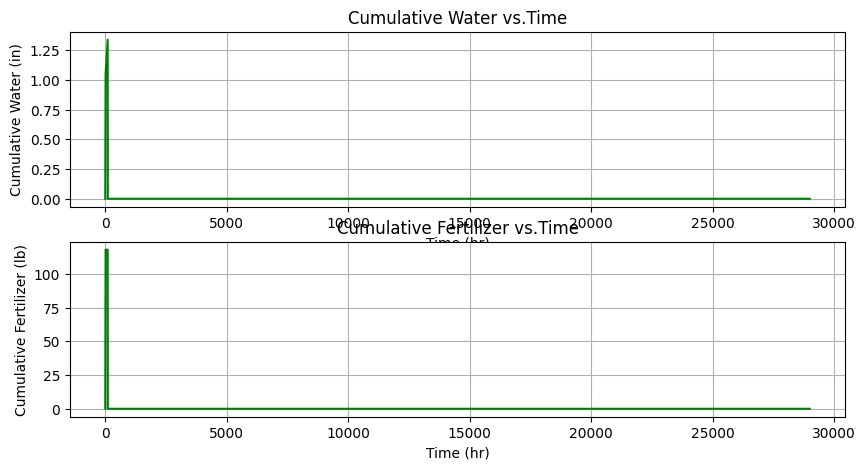

In [17]:
# Plot all of the cumulative values
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
total_time_steps = int(simulation_hours / dt)
time = np.arange(total_time_steps)

# Precipitation
axs[0].plot(time, cumulative_water, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Cumulative Water (in)')
axs[0].set_title(f'Cumulative Water vs.Time')
axs[0].grid(True)

# Radiation
axs[1].plot(time, cumulative_fertilizer, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Cumulative Fertilizer (lb)')
axs[1].set_title(f'Cumulative Fertilizer vs.Time')
axs[1].grid(True)

In [18]:
# Sample hourly for plotting
def sample_hourly(data, dt, simulation_hours):
    time_steps_per_hour = int(1 / dt)
    total_time_steps = int(simulation_hours / dt)
    sampled_data = np.zeros(simulation_hours)

    for i in range(0, total_time_steps, time_steps_per_hour):
        start_index = i
        end_index = i + time_steps_per_hour
        sampled_value = np.mean(data[start_index:end_index])
        j = int(i / time_steps_per_hour)  # Convert to hourly index
        sampled_data[j] = sampled_value

    return sampled_data

In [19]:
sampled_height           = sample_hourly(h, dt, simulation_hours)
sampled_leaf_area        = sample_hourly(A, dt, simulation_hours)
sampled_number_of_leaves = sample_hourly(N, dt, simulation_hours)
sampled_flower_size      = sample_hourly(c, dt, simulation_hours)
sampled_fruit_biomass    = sample_hourly(P, dt, simulation_hours)

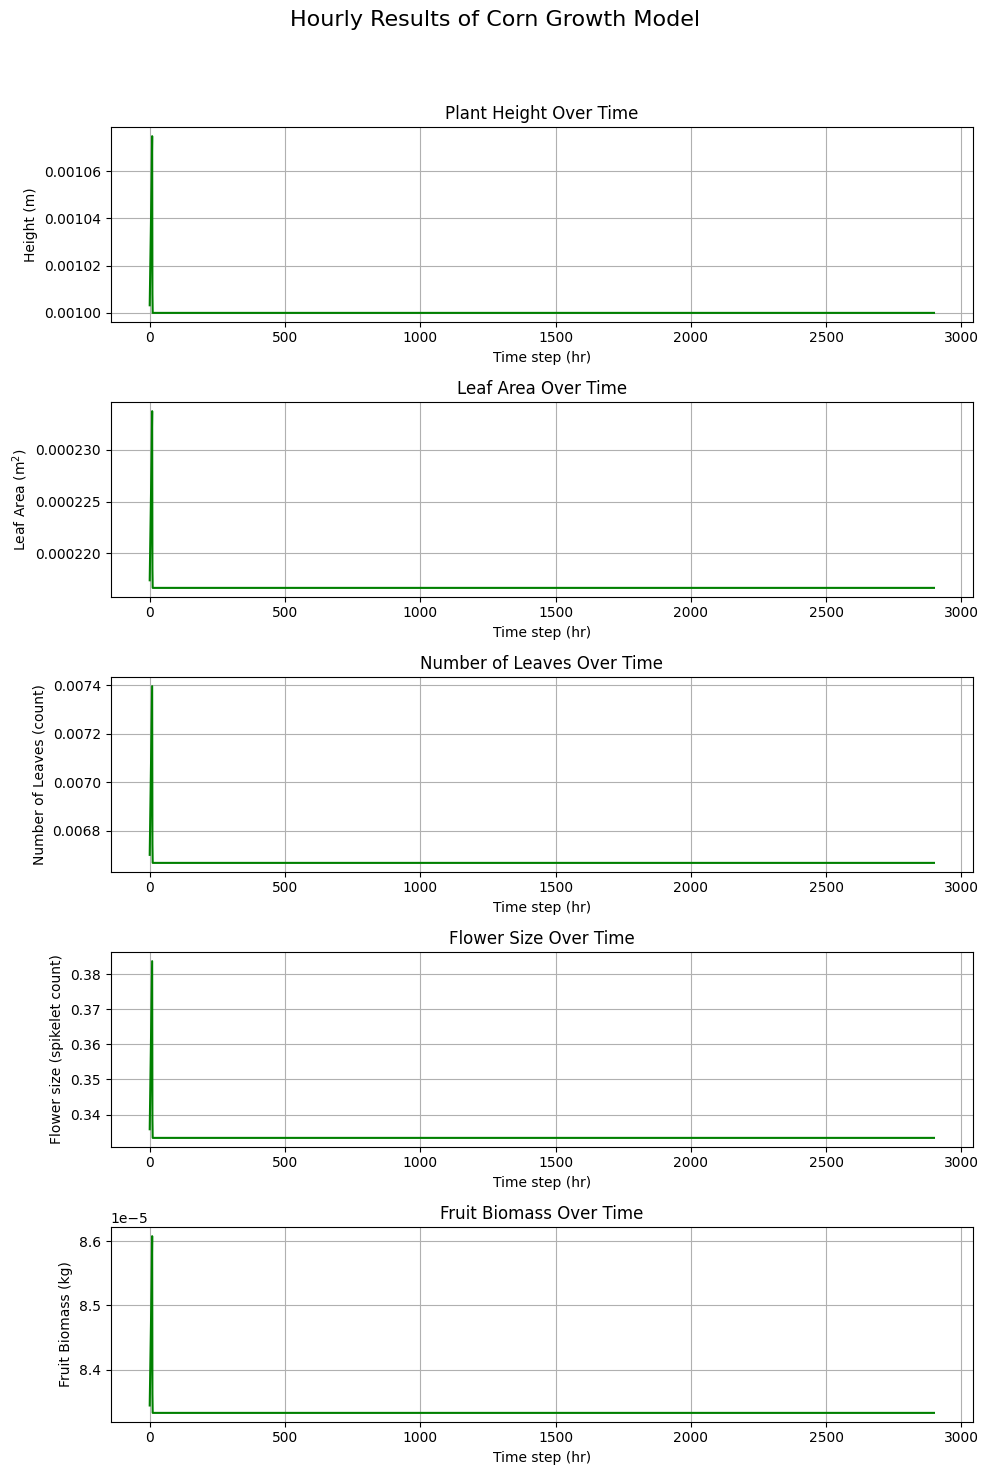

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to find the x-location of half-max point
def annotate_half_max(ax, y_data, label):
    y_max = np.max(y_data)
    half_max = y_max / 2
    tolerance = 0.01 * y_max  # 1% tolerance

    # Find first index where value is close to half max
    idx = np.where(np.abs(y_data - half_max) <= tolerance)[0]
    if len(idx) > 0:
        x_val = idx[0]
        y_val = y_data[x_val]
        ax.plot(x_val, y_val, 'ro')  # Red dot
        ax.axvline(x=x_val, color='red', linestyle='--', alpha=0.5)  # Vertical line
        ax.annotate(f'{label}: {x_val} hr', xy=(x_val, y_val), xytext=(x_val + 10, y_val),
                    arrowprops=dict(arrowstyle='->', color='red'), color='red', fontsize=9)

# Create the figure and axes
fig, axs = plt.subplots(5, 1, figsize=(10, 15))

# Height
axs[0].plot(np.arange(simulation_hours), sampled_height, color='green')
axs[0].set_xlabel('Time step (hr)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Plant Height Over Time')
axs[0].grid(True)
annotate_half_max(axs[0], sampled_height, 'Height ½-max')

# Leaf Area
axs[1].plot(np.arange(simulation_hours), sampled_leaf_area, color='green')
axs[1].set_xlabel('Time step (hr)')
axs[1].set_ylabel(r'Leaf Area (m$^{2}$)')
axs[1].set_title('Leaf Area Over Time')
axs[1].grid(True)
annotate_half_max(axs[1], sampled_leaf_area, 'Leaf Area ½-max')

# Number of leaves
axs[2].plot(np.arange(simulation_hours), sampled_number_of_leaves, color='green')
axs[2].set_xlabel('Time step (hr)')
axs[2].set_ylabel('Number of Leaves (count)')
axs[2].set_title('Number of Leaves Over Time')
axs[2].grid(True)
annotate_half_max(axs[2], sampled_number_of_leaves, 'Leaf Count ½-max')

# Flower size
axs[3].plot(np.arange(simulation_hours), sampled_flower_size, color='green')
axs[3].set_xlabel('Time step (hr)')
axs[3].set_ylabel('Flower size (spikelet count)')
axs[3].set_title('Flower Size Over Time')
axs[3].grid(True)
annotate_half_max(axs[3], sampled_flower_size, 'Flower Size ½-max')

# Fruit Biomass
axs[4].plot(np.arange(simulation_hours), sampled_fruit_biomass, color='green')
axs[4].set_xlabel('Time step (hr)')
axs[4].set_ylabel('Fruit Biomass (kg)')
axs[4].set_title('Fruit Biomass Over Time')
axs[4].grid(True)
annotate_half_max(axs[4], sampled_fruit_biomass, 'Fruit Biomass ½-max')

# Final layout and display
fig.suptitle('Hourly Results of Corn Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()